# An introduction to ML Fairness and Scikit-Learn

## Table of Contents

1. [Summary](#summary)
2. [Analyssis set-up](#setup)
3. [The data](#data-overview)
4. [Data prep](#data-prep)
5. [Exploration](#exploration)
6. [Machine learning analysis](#ml-1)
7. [Bias mitigation via preprocessing](#bias-mitigation-preprocessing)
8. [Bias mitigation via inprocessing](#bias-mitigation-inprocessing)
9. [End](#end)

## Summary <a name="summary"></a>

Welcome! The purpose of this notebook is to outline a very simple process for identifying and mitigating machine learning bias using fairlearn and imbalanced-learn. This post will rely on tried-and-true scikit learn best practices, so my hope is that it not only displays ways to handle potential project issues, but also how to properly structure a supervised learning analysis. With that introduction, let's get into the data! 

:rotating_light: The axis labels on the plots are black, so if you're in GitHub Dark Mode, you will need to switch to Light Mode to view them!

## Analysis set-up <a name="setup"></a>

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from fairlearn.metrics import MetricFrame, false_positive_rate, true_positive_rate, selection_rate, count, demographic_parity_ratio, equalized_odds_ratio
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier


Bad key text.latex.unicode in file C:\Users\allie\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\allie\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\allie\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/m

## The data <a name="data-overview"></a>

The data used in this analysis come from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). It represents Taiwanese credit card clients. Our goal will be to predict who is at risk of defaulting on their credit card payment next month, indicated by the variable *default payment next month*. 

The data include 23 variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: - X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [3]:
df = pd.read_excel("../data/default of credit card clients.xls", header = 1)
print(f"Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}")

Number of rows: 30000
Number of columns: 25


In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
df.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

## Data prep <a name="data-prep"></a>

Before we can do any machine learning modelling, we first need to prepare the data for analysis. It's not ready in its current form! In the cells below, I walk through various feature engineering steps, including:
- Check whether any rows have missing values and mitigate as-needed
- Generating binary representations of the categorical variables
- Mapping the *education* column to a label representation
- Zeroing out values less than 0 in strictly positive numerical categories
- Changing the int-coded variables to pd.numeric types
- One-hot encoding the education variable using `pd.get_dummies`

In [7]:
[(col, df[col].isnull().mean()) for col in df.columns.tolist()] #no missing values!

[('ID', 0.0),
 ('LIMIT_BAL', 0.0),
 ('SEX', 0.0),
 ('EDUCATION', 0.0),
 ('MARRIAGE', 0.0),
 ('AGE', 0.0),
 ('PAY_0', 0.0),
 ('PAY_2', 0.0),
 ('PAY_3', 0.0),
 ('PAY_4', 0.0),
 ('PAY_5', 0.0),
 ('PAY_6', 0.0),
 ('BILL_AMT1', 0.0),
 ('BILL_AMT2', 0.0),
 ('BILL_AMT3', 0.0),
 ('BILL_AMT4', 0.0),
 ('BILL_AMT5', 0.0),
 ('BILL_AMT6', 0.0),
 ('PAY_AMT1', 0.0),
 ('PAY_AMT2', 0.0),
 ('PAY_AMT3', 0.0),
 ('PAY_AMT4', 0.0),
 ('PAY_AMT5', 0.0),
 ('PAY_AMT6', 0.0),
 ('default payment next month', 0.0)]

In [8]:
df["male"] = np.where(df.SEX == 1, 1, 0)
df["under30"] = np.where(df.AGE < 30, 1, 0)
df["unmarried"] = np.where(df.MARRIAGE ==2, 1, 0)
df.rename(columns = {'default payment next month':'y'}, inplace = True)

educ_dict = {"EDUCATION": ["1", "2", "3", "4"], "EDUC_LEVEL": ["graduate_school", "university", "high_school", "other"]}
df["EDUCATION"] = df.EDUCATION.astype(str)
df = pd.merge(df, pd.DataFrame(educ_dict), on = "EDUCATION")

for col in ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    df.loc[df[col] < 0, col] = 0

In [9]:
for col in ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6']: # int type columns
    df[col] = df[col].astype(float)

df = pd.get_dummies(df, prefix = "educ_", columns = ["EDUC_LEVEL"], drop_first = True)

## Exploration <a name="exploration"></a>

Now that the data is prepped, let's view how the distribution of our target variable changes across classes. Of particular interest to me are the *SEX*, *Under 30*, and *Unmarried* columns, as those could all be potentially encoding historical biases. 

<AxesSubplot:>

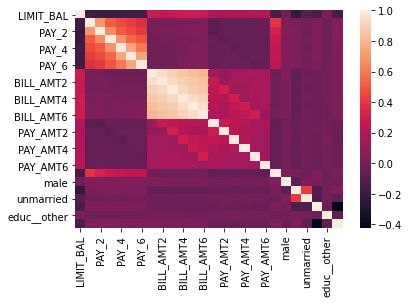

In [10]:
# Observing pairwise correlations; most of the variables (outside of the bill amounts) are not correlated.
corr = df.drop(columns = ["SEX", "AGE", "MARRIAGE", "ID", "EDUCATION"], axis = 1).corr()
sns.heatmap(corr)

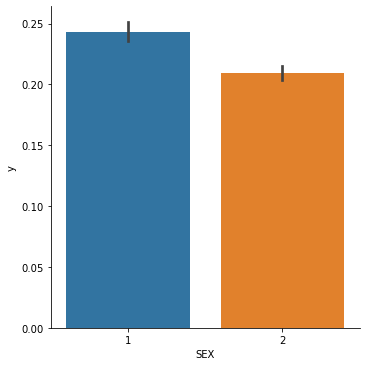

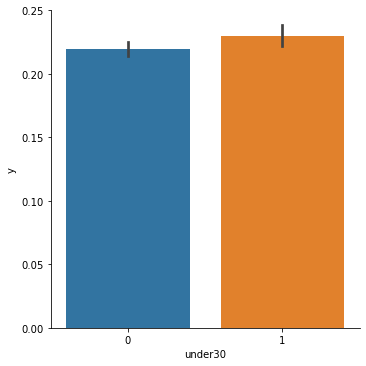

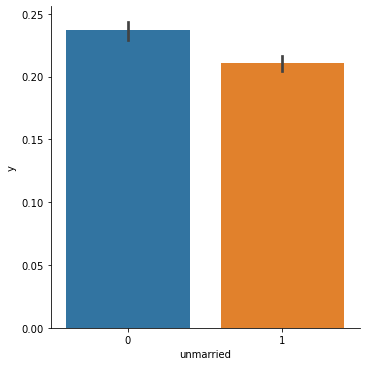

In [11]:
# NOTE: Sex = 1 if MALE and 2 if FEMALE
for col in ["SEX", "under30", "unmarried"]:
    sns.catplot(x = col, y = "y",  kind="bar", data = df)

The catplots above show the following results: 
- Women default on their credit card payments less frequently than men do
- Credit card holders under age 30 default on their payments slightly more frequently than those over 30 do
- Unmarried individuals default on their payments slightly less than married individuals do

Our classification model is going to pick up on these trends and use them to predict the likelihood of defaulting on a payment. The only result that looks slightly suspicious to me is that younger credit card holders default on their payments more often. My worry is that the model may reflect this reality by classifying younger folks are more likely to default, even when that isn't the case! Let's move on to the modelling stage to see if that happens.

## Machine learning analysis <a name="ml-1"></a>

A priori, I don't know which classification model is going to give me the best fit. So the strategy I am going to take instead of fitting different models one-by-one is running a pipeline fit through a series of popular classifiers in an automated fashion. I'm going to use the `fit_predict_score` function I defined earlier to perform the following steps:
1. Create a pipeline with the steps Standard Scalar (scale the numerical features to have a standard normal distribution) and fit a classifier
2. Split the data into train and test sets
3. Fit the pipeline to the training data
4. Generate the predicted values
5. Return the accuracy score
All the results will be appended to the `results` list, and I'll show you which ones performed the best (by the accuracy score, that is!)

In [12]:
# Dropping the old variables that we recoded earlier
X = df.drop(columns = ["SEX", "AGE", "MARRIAGE", "ID", "EDUCATION", "y"], axis = 1)
y = df.y

In [13]:
# define the models we want to test
models = [
    SVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

results = []

# run models
for estimator in models:
    
    # pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('estimator', estimator)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    # Fit models
    pipe.fit(X_train, y_train)
    
    # Generate predictions
    expected = y_test
    predicted = pipe.predict(X_test)
    score = accuracy_score(y_true = expected, y_pred = predicted), expected, predicted, X_test

    # Compute and return F1 (harmonic mean of precision and recall)
    results.append((estimator.__class__.__name__, score) )

print(sorted(results, key = lambda s: s[1], reverse= True))

[('SVC', 0.8199352576207176), ('LogisticRegression', 0.8156190990018883), ('LogisticRegressionCV', 0.8156190990018883), ('RandomForestClassifier', 0.8156190990018883), ('LinearSVC', 0.8154842190450499), ('SGDClassifier', 0.8111680604262207), ('ExtraTreesClassifier', 0.8069867817642299), ('BaggingClassifier', 0.8024008632317238), ('KNeighborsClassifier', 0.7874291880226598)]


So the best classifier by accuracy is the `SGDClassifier`, which implements a regularized linear model with stochastic gradient descent (SGD) learning. It achieves an accuracy of 82%. That's not great! Let's see how the evaluation metrics break down across the attributes we deemed as sensitive.

In [14]:
pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('estimator', SGDClassifier(max_iter=100, tol=1e-3)))
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe.fit(X_train, y_train)
    
expected = y_test
predicted = pipe.predict(X_test)

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}

Let's start by assessing parity across gender. We'll review how the model performs across a variety of different evaluation metrics for each gender.

      accuracy precision    recall false positive rate true positive rate  \
male                                                                        
0     0.818082  0.619403  0.348374            0.056951           0.348374   
1     0.810698  0.686076  0.391618            0.056699           0.391618   

     selection rate count  
male                       
0          0.118192  4535  
1            0.1372  2879  


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='male'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='male'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='male'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='male'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='male'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='male'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='male'>,
        <AxesSubplot:xlabel='male'>, <AxesSubplot:xlabel='male'>]],
      dtype=object)

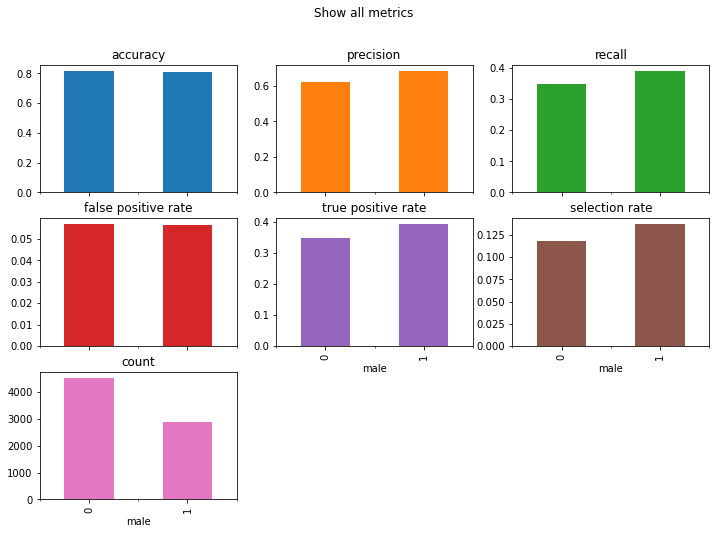

In [15]:
gender_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=testdata["male"])
print(gender_frame.by_group)

gender_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

Okay, so as you can see above, the model is actually likelier to classify men as defaulting on a payment even when in reality they did not (false positive class). Men also have a higher *selection rate*, or percentage of the population which have ‘1’ as their label. Let's also look at the few boilerplate fair ML classification metrics to make sure nothing sketchy is going on.

In [16]:
# Demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate across all sensitive attributes
# The closer to 1, the better!
d = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["male"])

# Equalized odds ratio is defined as the smaller of two metrics: true_positive_rate_ratio and false_positive_rate_ratio
# The closer to 1, the better!
e = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["male"])

print(f"Demographic parity ratio: {d}\nEqualized odds ratio: {e}")

Demographic parity ratio: 0.8614539516838094
Equalized odds ratio: 0.8895738065460402


Both ratios are close to 1, which is pretty good but not perfect. How does this analysis change for the *under30* variable?

         accuracy precision    recall false positive rate true positive rate  \
under30                                                                        
0        0.819093  0.654687  0.380909            0.056871           0.380909   
1        0.807249  0.632302  0.337615            0.056824           0.337615   

        selection rate count  
under30                       
0             0.128359  4986  
1             0.119852  2428  
Demographic parity ratio: 0.9337198826194398
Equalized odds ratio: 0.8863392524796917


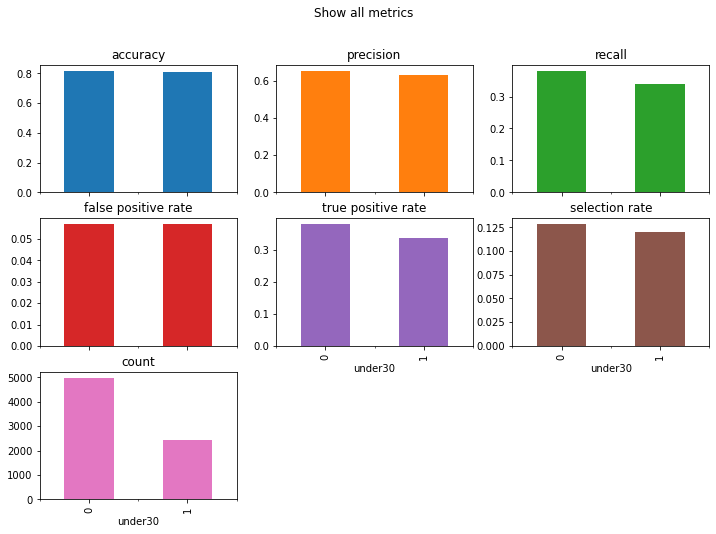

In [17]:
age_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
print(age_frame.by_group)

age_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

d = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
e = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])

print(f"Demographic parity ratio: {d}\nEqualized odds ratio: {e}")

The fairness metrics are far worse for the *under30* variable. Credit card holders under age 30 are erroneously predicted as likely to default (see the false positive rate). If you look at the count graph, you'll also see that there are way less observations for the under 30 group. One potential way to mitigate bias in our results is to reconstruct our dataset so that we have more representations of the minority group. 

In a machine learning analysis, there are three places where bias mitigation can occur:
1. Preprocessing: Preprocessing involves identifying data gaps before the machine learning analysis begins. Typically, this can involve resampling/reweighting data to increase representation of underrepresented minority groups and feature engineering by modyfing the labels or label-data pairs.
2. In-processing: In-processing involes including a regularization parameter to a model to optimize the model for fairness while it's training. 
3. Post-processing: Post-processing involves changing the thresholds of the evaluation metric you're using to incorporate fairness goals.

In an ideal world, bias mitigation would begin before machine learning starts. It's easier to achieve the goals of fairness AND accuracy, precision, AOC_RUC score, etc. if we rewight/resample the data before running a model. Why is this the case? Well, during in-processing, if you're trying to achieve an outcome while adhering to a fairness constraint, your outcome may be worse off than if the constraint was not there. Similarly, if you're adjusting the threshold of an evaluation metric to accomodate a fairness constraint, even if you get the metric to an acceptable level, that metric is reflective of the model's capability to pick up on signals in the data, and one signal is data bias. I've explained this before as garbage-in, garbage-out; even if you dress up the garbage you get from the model, that doesn't change the fact that garbage was used to produce it!

In the section below, I attempt to address the disparate outcomes for younger credit card holders using resampling.

## Bias mitigation via preprocessing <a name="bias-mitigation-preprocessing"></a>

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Redo the pipeline with the SMOTE parameter added in and reassess the results

pipe = make_pipeline(SMOTE(random_state=0), StandardScaler(with_mean=False), SGDClassifier(max_iter=100, tol=1e-3) )

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
pipe.fit(X_train, y_train)

y_true = y_test
y_pred = pipe.predict(X_test)

         accuracy precision    recall false positive rate true positive rate  \
under30                                                                        
0        0.760931  0.460951  0.493636            0.163407           0.493636   
1        0.796129   0.57716  0.343119            0.072756           0.343119   

        selection rate count  
under30                       
0             0.236262  4986  
1             0.133443  2428  
Demographic parity ratio: 0.5648112149428148
Equalized odds ratio: 0.4452452737088161


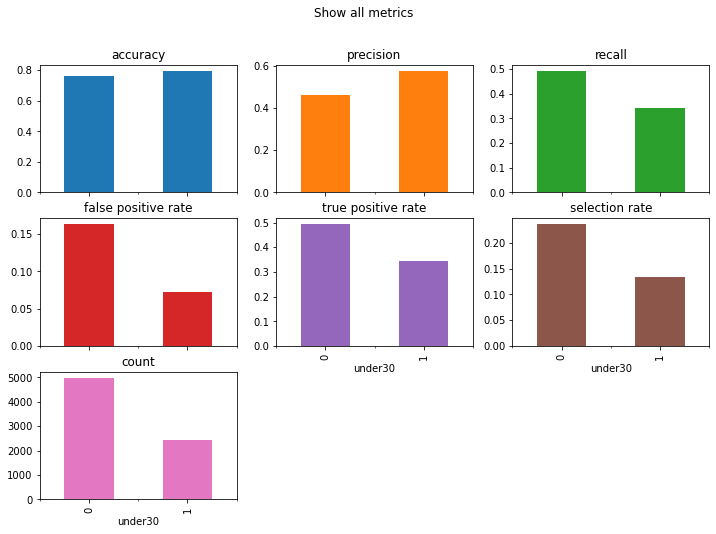

In [19]:
age_frame = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])

age_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

print(age_frame.by_group)

d = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
e = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
print(f"Demographic parity ratio: {d}\nEqualized odds ratio: {e}")

After applying SMOTE resampling, we can see that younger applicants now have a lower false positive and lower selection rate than they did previously. The count reflects the underrepresentation in the original dataset and should be ignored. Because  outcomes for the under-30 group are now better across the board, demographic parity and equalized odds suffer. In a more rigorous analysis, I'd experiment with other sampling and reweighting schemes to get as close to equal outcomes between groups as possible. 

## Bias mitigation via inprocessing <a name="bias-mitigation-inprocessing"></a>

In the cell below, I apply an inprocessing method, a reduction (of the demographic parity flavor) to constrain the SDG classifier along a fairness requirement. 

In [20]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

dp = DemographicParity(difference_bound=0.01)
reduction = ExponentiatedGradient(SGDClassifier(max_iter=100, tol=1e-3), dp)

reduction.fit(X_train, y_train, sensitive_features=X_train["under30"])
y_pred = reduction.predict(X_test, random_state = 0)

age_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=X_test["under30"])

print(age_frame.by_group)

d = demographic_parity_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
e = equalized_odds_ratio(y_true=y_true, y_pred=y_pred, sensitive_features=testdata["under30"])
print(f"Demographic parity ratio: {d}\nEqualized odds ratio: {e}")

         accuracy precision recall false positive rate true positive rate  \
under30                                                                     
0        0.779382       0.0    0.0                 0.0                0.0   
1        0.775535       0.0    0.0                 0.0                0.0   

        selection rate count  
under30                       
0                  0.0  4986  
1                  0.0  2428  
Demographic parity ratio: nan
Equalized odds ratio: nan


As you can see in the results above, nearly every evaluation metric is zeroed out. Demographic parity and equalized odds are also missing. I'd consider these results to be unstable. If I wanted to improvde precision and recall across both groups, I'd continue to toggle the `DemographicParity()` constraint until I attained satisfactory results. The fairlearn documentation notes that picking the appropriate evaluation metric constraint is crucial, and in a real-world situation, this is something that I or my team would have determined ahead of time in accordance with the machine learning project's goals.

In a more rigorous analysis, I'd also do a grid search on the hyperparameters of the SDG classifier to ensure I got the best fit.

## End <a name="end"></a>

Thank you for reading :smile:. If you'd like to learn more about ML fairness, check out [my presentation](https://docs.google.com/presentation/d/e/2PACX-1vRv7_luengkBK33VtRxdLIdbYiFb-bOH-FeN2zTsyqHQHFAY7PXnOXARIA-s6lglhT6fVLb8sGDs6a3/pub?start=false&loop=false&delayms=10000) on the topic and the [the fairlearn documentation](https://fairlearn.org/main/user_guide/fairness_in_machine_learning.html#fairness-in-machine-learning)! 